
# Analyzing Fairness and Bias in Crime Prediction Models

This tutorial investigates bias and fairness in predictive policing models. 
Using the Communities and Crime dataset, we explore the implications of using potentially imbalanced data and propose methods for improving fairness.
The main objectives are:

- Understand how bias manifests in the dataset and predictive models.
- Evaluate fairness metrics to measure the impact of these biases.
- Explore techniques to mitigate bias and assess their effectiveness.

Let's begin by exploring the dataset and understanding its structure.


In [1]:
! pip install ucimlrepo
! pip install matplotlib
! pip install scikit-learn
! pip install seaborn

In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

##### Load Dataset

In [3]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 
  
# metadata 
metadata = communities_and_crime.metadata
  
# variable information 
variables = communities_and_crime.variables

print(metadata)
print(variables)

{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'ID': 405, 'type': 'NATIVE', 'title': 'A data-driven software tool for enabling cooperative information s

In [4]:
# Convert to a dataframe
df = pd.concat([X, y], axis=1)

df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [5]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Check for missing values again
print(df.isnull().sum())

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64


##### Data Preprocessing

In [6]:
# Remover as colunas com valores ausentes
df = df.dropna(axis=1)

In [7]:
df

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,6,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,9,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


In [8]:
X = df.drop('ViolentCrimesPerPop', axis=1)
y = df['ViolentCrimesPerPop']

In [9]:
# Select numeric columns
numerical_columns = df.select_dtypes(include=['number'])

In [10]:
# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numerical_columns)

In [11]:
df

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,6,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,9,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


In [12]:
# Remover a coluna 'communityname'
df = df.drop(columns=['communityname'])

# Realizar o one-hot encoding na coluna 'state'
df = pd.get_dummies(df, columns=['state'], prefix='state')

df = df.astype(int) 

# Exibir o DataFrame resultante
df

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,state_46,state_47,state_48,state_49,state_50,state_51,state_53,state_54,state_55,state_56
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1991,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1992,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Model Predict

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Definir o modelo
model = RandomForestRegressor(random_state=42)

# Usar cross_val_score para calcular o MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Negativo porque queremos minimizar o erro
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring=mse_scorer)

# Usar cross_val_score para calcular o MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Negativo porque queremos minimizar o erro
cv_scores_mae = cross_val_score(model, X_scaled, y, cv=5, scoring=mae_scorer)

# Calcular o MSE médio
mean_mse = -cv_scores.mean()  # Tornar positivo novamente

# Calcular o MAE médio
mean_mae = -cv_scores_mae.mean()  # Tornar positivo novamente

# Exibir os resultados
print("MSE por fold:", -cv_scores)  # MSE de cada fold
print("MSE médio:", mean_mse)

print("MAE por fold:", -cv_scores_mae)  # MAE de cada fold
print("MAE médio:", mean_mae)

MSE por fold: [9.72481203e-07 1.12849624e-06 1.04669173e-06 1.60007519e-06
 9.08216080e-07]
MSE médio: 1.131192088260823e-06
MAE por fold: [0.0002802  0.00025539 0.00024637 0.00025689 0.00021683]
MAE médio: 0.0002511362577298621


Erros extremamente pequenos => modelo está bem ajustado ao dataset

##### Evaluate Fairness

In [14]:
list(df.columns)

['fold',
 'population',
 'householdsize',
 'racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'agePct12t21',
 'agePct12t29',
 'agePct16t24',
 'agePct65up',
 'numbUrban',
 'pctUrban',
 'medIncome',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'medFamInc',
 'perCapInc',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'HispPerCap',
 'NumUnderPov',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctNotHSGrad',
 'PctBSorMore',
 'PctUnemployed',
 'PctEmploy',
 'PctEmplManu',
 'PctEmplProfServ',
 'PctOccupManu',
 'PctOccupMgmtProf',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PersPerFam',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMomYoungKids',
 'PctWorkMom',
 'NumIlleg',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctImmigRec5',
 'PctImmigRec8',
 'PctImmigRec10',
 'PctRecentImmig',
 'PctRecImmig5',
 'PctRecImmig8',
 'PctRecImmig10',
 'PctSpeakEnglOnly',

In [15]:
race_columns = ['racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'HispPerCap'
]

## Fairness Metrics

In this analysis, we will use the following fairness metrics:

1. **Demographic Parity**: Ensures that positive predictions are equally likely across all groups.
2. **Equalized Odds**: Ensures equal true positive and false positive rates across groups.

By measuring these metrics, we can evaluate the presence of bias in our predictive models and compare mitigation techniques.


Exploring target and group feature distributions...



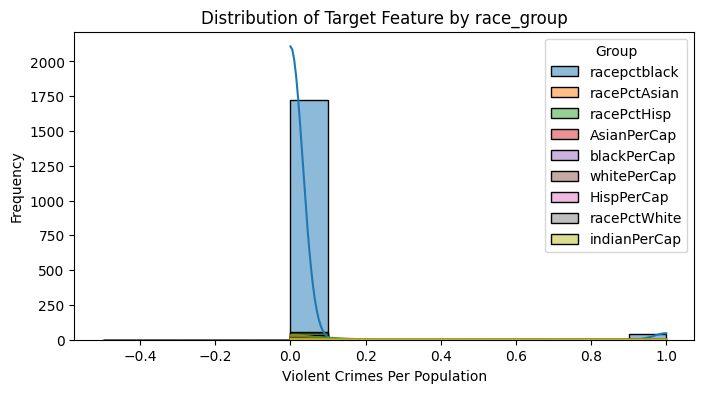

Exploring race-related features distributions...



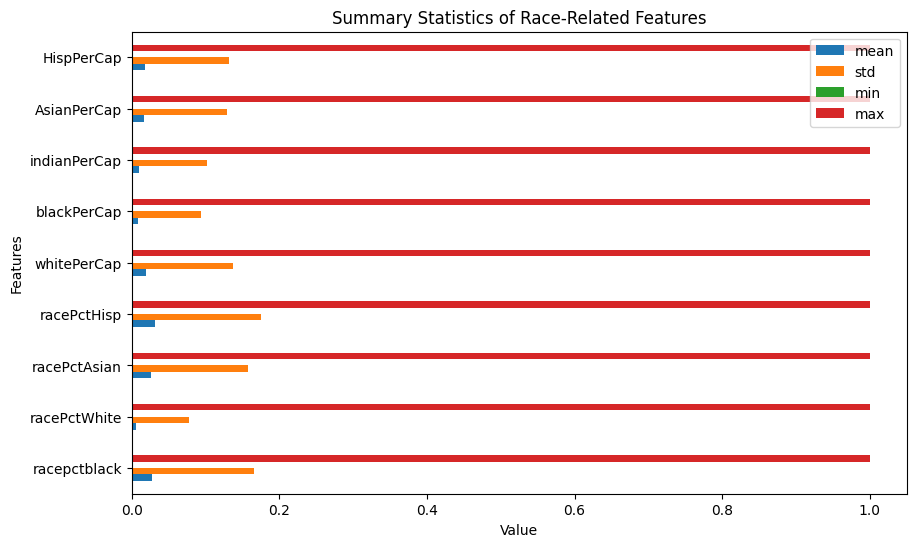

In [16]:
# Define target and group feature
target_feature = 'ViolentCrimesPerPop'  # Replace with actual target column name
group_feature = 'race_group'  # Replace with actual group column, if exists


# Criar o race_group com base nas colunas de raça
def assign_race_group(row, race_columns):
    max_race = row[race_columns].idxmax()  # Encontrar a coluna com o maior valor percentual
    return max_race

df['race_group'] = df.apply(lambda row: assign_race_group(row, race_columns), axis=1)

# Visualizar a distribuição da variável-alvo
def plot_class_distribution(data, target_feature, group_feature=None, bins=10):
    plt.figure(figsize=(8, 4))
    
    if group_feature:
        # Histograma da variável-alvo para diferentes grupos
        for group in data[group_feature].unique():
            sns.histplot(
                data[data[group_feature] == group][target_feature],
                bins=bins, label=f"{group}", kde=True, alpha=0.5
            )
        plt.legend(title="Group")
    else:
        # Histograma geral da variável-alvo
        sns.histplot(data[target_feature], bins=bins, kde=True, color="skyblue", alpha=0.7)

    plt.title("Distribution of Target Feature" + (f" by {group_feature}" if group_feature else ""))
    plt.xlabel("Violent Crimes Per Population")
    plt.ylabel("Frequency")
    plt.show()

# Visualizar estatísticas das colunas relacionadas à raça
def plot_race_distributions(data, race_columns):
    race_stats = data[race_columns].describe().T[['mean', 'std', 'min', 'max']]
    race_stats.plot(kind='barh', figsize=(10, 6), legend=True)
    plt.title("Summary Statistics of Race-Related Features")
    plt.xlabel("Value")
    plt.ylabel("Features")
    plt.show()

# Função para explorar os dados combinados
def explore_data(data, target_feature, group_feature, race_columns):
    print("Exploring target and group feature distributions...\n")
    plot_class_distribution(data, target_feature, group_feature)
    
    print("Exploring race-related features distributions...\n")
    plot_race_distributions(data, race_columns)

# Chamar a função
explore_data(df, target_feature, group_feature, race_columns)


The first graph shows the distribution of the variable **ViolentCrimesPerPop**, which represents the proportion of violent crimes relative to the population. Most observations are concentrated within the range of 0.0 to 0.2 for **ViolentCrimesPerPop**, indicating that the majority of areas in the dataset experience low violent crime rates. The frequency declines sharply as the crime rate increases. For instance, very few areas have **ViolentCrimesPerPop** values exceeding 0.6. Extremely high crime rates, nearing 1.0, are rare, suggesting that such cases are outliers or uncommon.

The data is segmented by racial or demographic groups (e.g., racePctWhite, racepctblack, racePctAsian, etc.), each represented by different colors in the graph.
#### **Dominance of racePctWhite**
The distribution for racePctWhite (shown in blue) dominates the graph, both in terms of frequency and range. This suggests that areas with a high proportion of white populations (racePctWhite) make up the majority of observations in the dataset. These areas predominantly fall within the lower ranges of ViolentCrimesPerPop (0.0–0.2), reinforcing the idea that these areas are associated with lower crime rates.

#### **Other Groups (racepctblack, racePctAsian, etc.)**
Other groups, such as racepctblack, racePctAsian, racePctHisp, and blackPerCap, exhibit significantly lower frequencies across all ranges of ViolentCrimesPerPop. This suggests that:
- These groups are underrepresented in the dataset, or
- Areas with higher concentrations of these groups are fewer in number or cover smaller populations.
The curves for these groups are flatter, indicating that their observations are more dispersed across the crime rate spectrum compared to the dominant racePctWhite group.


The second graph, provides a summary of the statistical distribution of various race-related features in the dataset. It includes the mean, standard deviation (std), minimum (min), and maximum (max) values for each feature, represented as horizontal bars.

The features in this dataset relate to the proportions of different racial groups in the population, including:
- HispPerCap (Hispanic per capita)
- AsianPerCap (Asian per capita)
- indianPerCap (Indian per capita)
- blackPerCap (Black per capita)
- whitePerCap (White per capita)
- racePctHisp (Percentage of Hispanic population)
- racePctAsian (Percentage of Asian population)
- racePctWhite (Percentage of White population)
- racePctblack (Percentage of Black population)

The mean values (blue bars) for these features are spread across different ranges from 0.0 to 0.77. This suggests that there is a substantial variation in the racial composition of different areas in the dataset.
For example, ``racePctWhite`` and ``racePctblack`` have relatively higher means, indicating that the areas in the dataset contain a significant portion of White and Black populations, respectively.
``HispPerCap`` and ``blackPerCap`` show a smaller spread, suggesting lower but notable proportions of Hispanic and Black populations per capita.

In [17]:

"""from sklearn.metrics import confusion_matrix

# Define a function to calculate demographic parity and equalized odds
def fairness_metrics(y_true, y_pred, group, positive_label=1):
    results = {}
    for g in group.unique():
        mask = group == g
        cm = confusion_matrix(y_true[mask], y_pred[mask], labels=[0, positive_label])
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate metrics
        results[g] = {
            "Demographic Parity": (tp + fp) / len(group[mask]),
            "True Positive Rate": tp / (tp + fn) if (tp + fn) > 0 else 0,
            "False Positive Rate": fp / (fp + tn) if (fp + tn) > 0 else 0,
        }
    return pd.DataFrame(results).T

# Assuming `predictions` and `actual` are available from modeling
fairness_df = fairness_metrics(y_true, y_pred, df[group_feature])
print(fairness_df)"""


'from sklearn.metrics import confusion_matrix\n\n# Define a function to calculate demographic parity and equalized odds\ndef fairness_metrics(y_true, y_pred, group, positive_label=1):\n    results = {}\n    for g in group.unique():\n        mask = group == g\n        cm = confusion_matrix(y_true[mask], y_pred[mask], labels=[0, positive_label])\n        tn, fp, fn, tp = cm.ravel()\n        \n        # Calculate metrics\n        results[g] = {\n            "Demographic Parity": (tp + fp) / len(group[mask]),\n            "True Positive Rate": tp / (tp + fn) if (tp + fn) > 0 else 0,\n            "False Positive Rate": fp / (fp + tn) if (fp + tn) > 0 else 0,\n        }\n    return pd.DataFrame(results).T\n\n# Assuming `predictions` and `actual` are available from modeling\nfairness_df = fairness_metrics(y_true, y_pred, df[group_feature])\nprint(fairness_df)'